In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path
import scvi

from scib_metrics.benchmark import Benchmarker, BioConservation

%matplotlib inline

In [2]:
TEAM_NAMES = ["asap-cohort", "team-lee", "team-hafler", "team-jakobsson"]

# for team_name in TEAM_NAMES:
#     adata = sc.read('artifacts/{}.adata_object.scvi_integrated.umap_cluster.annotate_cells.h5ad'.format(team_name))
#     adata.obs['team'] = team_name

#     if team_name == TEAM_NAMES[0]:
#         adata_all = adata
#     else:
#         adata_all = adata_all.concatenate(adata, batch_key='team')

In [32]:
team_name = TEAM_NAMES[0]


filen = Path(f"artifacts/{team_name}.merged_adata_object.h5ad")
adata = sc.read(filen)

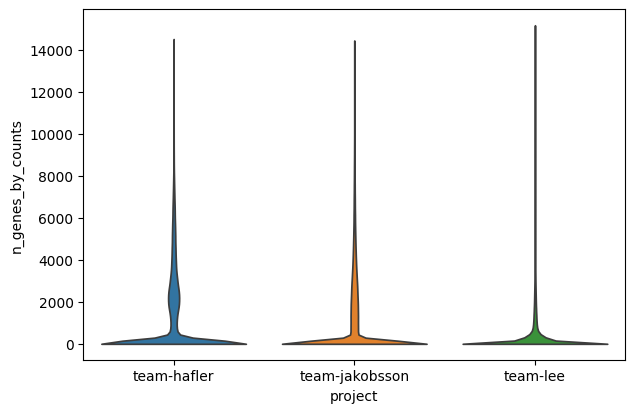

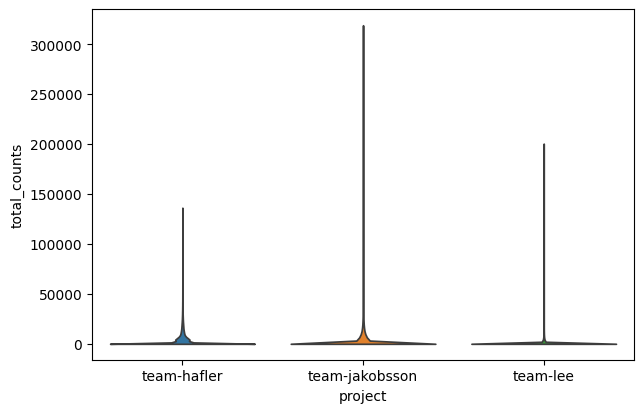

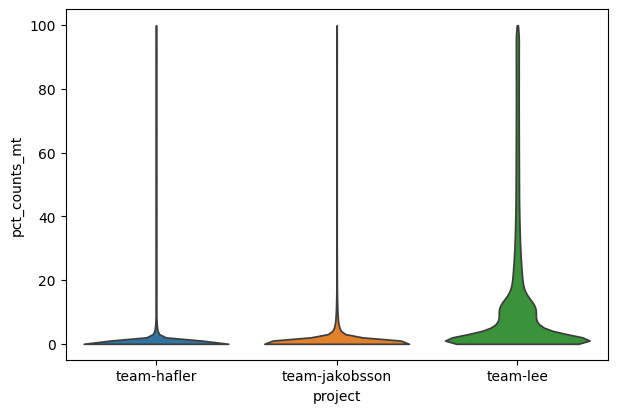

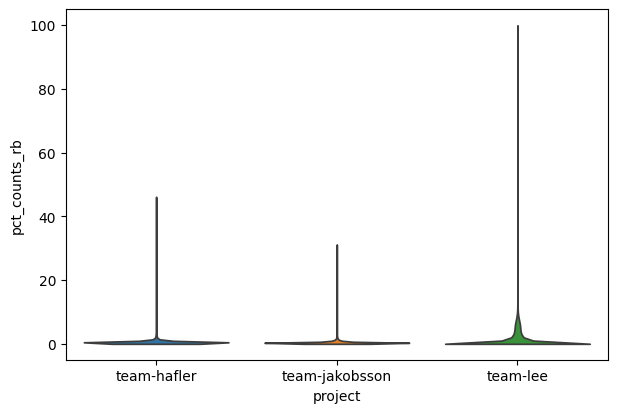

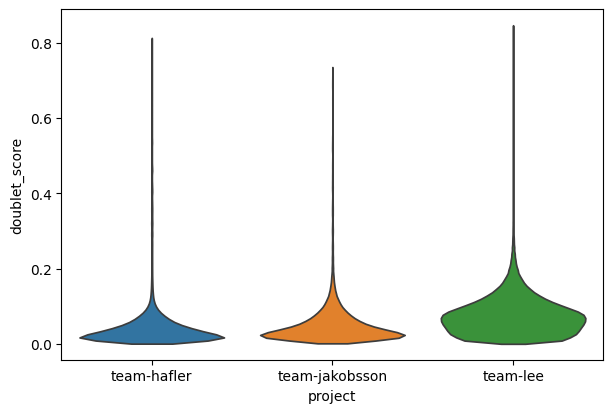

In [4]:
metrics = [
    "n_genes_by_counts",
    "total_counts",
    "pct_counts_mt",
    "pct_counts_rb",
    "doublet_score",
]

for metric in metrics:  # type: ignore
    sc.pl.violin(
        adata, groupby="project", keys=metric, size=0, save="".join("_" + metric)
    )

In [20]:
df = adata.obs[
    [
        "project",
        "n_genes_by_counts",
        "total_counts",
        "pct_counts_mt",
        "pct_counts_rb",
        "doublet_score",
    ]
].copy()
df["predicted_doublet"] = df["doublet_score"] > 0.2

In [25]:
df.value_counts("predicted_doublet")

predicted_doublet
False    1940676
True       22356
Name: count, dtype: int64

In [46]:
filen = Path(f"artifacts/{team_name}.merged_adata_object.h5ad")
adata = sc.read(filen)

pre = adata.obs.value_counts("project")

In [40]:
print(f"adata shape: {adata.shape} before filtering")
# Calculate the 95th percentile for total_counts and n_genes_by_counts (after restricting to cells with min_counts and min_genes)
max_counts_ = np.percentile(adata.obs["total_counts"], 99)
max_genes_ = np.percentile(adata.obs["n_genes_by_counts"], 99)
print(f"99pctile max_counts: {max_counts_}, max_genes: {max_genes_} before filtering")

adata = adata[adata.obs["pct_counts_mt"] <= 10, :]
adata = adata[adata.obs["doublet_score"] < 0.2, :]

# Define QC cutoffs
min_counts = 500
min_genes = 300

# Calculate the 95th percentile for total_counts and n_genes_by_counts (after restricting to cells with min_counts and min_genes)
max_counts = np.percentile(adata.obs["total_counts"], 99)
max_genes = np.percentile(adata.obs["n_genes_by_counts"], 99)

# Filter cells based on QC metrics
adata = adata[adata.obs["total_counts"] >= min_counts, :]
adata = adata[adata.obs["total_counts"] <= max_counts, :]
adata = adata[adata.obs["n_genes_by_counts"] >= min_genes, :]
adata = adata[adata.obs["n_genes_by_counts"] <= max_genes, :]


print(f"adata shape: {adata.shape} after filtering")
print(f"99pctile max_counts: {max_counts}, max_genes: {max_genes} after filtering")
post = adata.obs.value_counts("project")

adata shape: (1963032, 36601) before filtering
99pctile max_counts: 27449.0, max_genes: 6618.0 before filtering
adata shape: (457507, 36601) after filtering
99pctile max_counts: 41794.35000000021, max_genes: 7846.0 after filtering


In [45]:
# overall filter fraction
print("Overall filter fraction")
print(f"Total cells: {pre.sum()}")
print(f"Cells after filtering: {post.sum()}")
print(f"Fraction of cells kept: {post.sum()/pre.sum()}")

# filter fraction by project
print("Filter fraction by project")
print(f"Total cells: {pre}")
print(f"Cells after filtering: {post}")
print(f"Fraction of cells kept: {post/pre}")
print(f"percent change: {100*(post/pre-1)}")

Overall filter fraction
Total cells: 1963032
Cells after filtering: 457507
Fraction of cells kept: 0.23306140704787287
Filter fraction by project
Total cells: project
team-lee          1316419
team-jakobsson     431587
team-hafler        215026
Name: count, dtype: int64
Cells after filtering: project
team-lee          233364
team-jakobsson    144963
team-hafler        79180
Name: count, dtype: int64
Fraction of cells kept: project
team-lee          0.177272
team-jakobsson    0.335884
team-hafler       0.368235
Name: count, dtype: float64
percent change: project
team-lee         -82.272817
team-jakobsson   -66.411639
team-hafler      -63.176546
Name: count, dtype: float64


In [34]:
max_genes_, max_genes, max_counts_, max_counts

(6618.0, 7846.0, 27449.0, 41794.35000000021)

In [35]:
adata.shape

(457507, 36601)

total_counts    Axes(0.1,0.15;0.8x0.75)
dtype: object

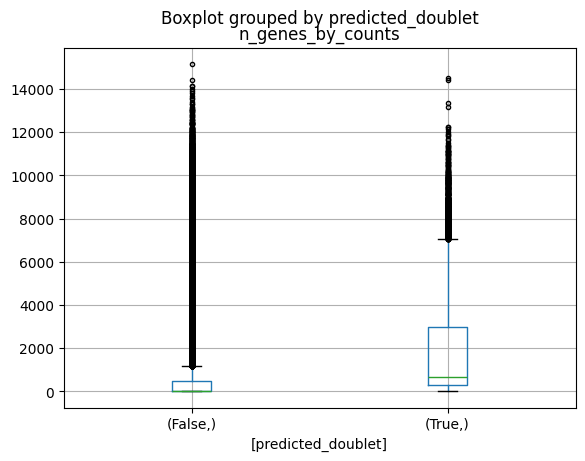

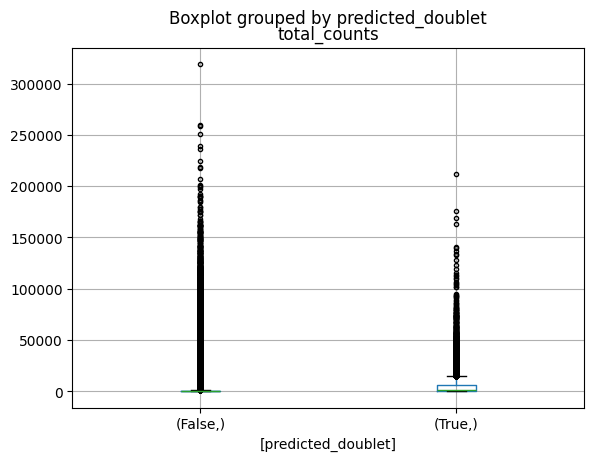

In [22]:
df.boxplot(
    column=["n_genes_by_counts"], by=["predicted_doublet"], return_type="axes", sym="."
)


df.boxplot(
    column=["total_counts"], by=["predicted_doublet"], return_type="axes", sym="."
)

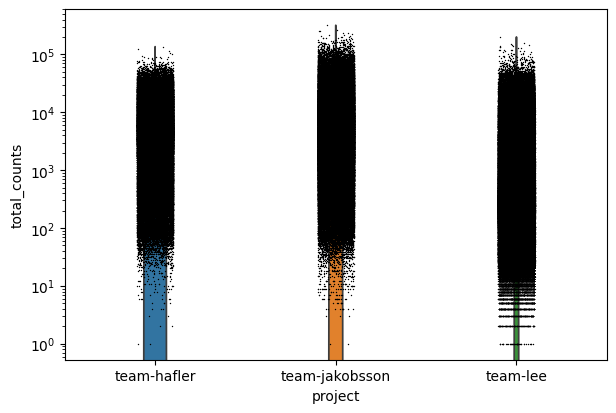

In [15]:
sc.pl.violin(
    adata,
    groupby="project",
    keys="total_counts",
    log=True,  # size=0, save="".join("_" + metric)
)

In [17]:
adata.uns["scrublet"]

{'parameters': {'expected_doublet_rate': 0.05,
  'random_state': 0,
  'sim_doublet_ratio': 2.0}}

Lets first test our new metrics

In [17]:
team_name = TEAM_NAMES[0]

In [18]:
filen = Path(f"artifacts/{team_name}.merged_adata_object_filtered_normalized.h5ad")
adata = sc.read(filen)

In [19]:
adata.obs_keys()

['background_fraction',
 'cell_probability',
 'cell_size',
 'droplet_efficiency',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_rb',
 'pct_counts_rb',
 'total_counts_mt',
 'pct_counts_mt',
 'doublet_score',
 'sample',
 'batch',
 'project',
 'batch_id',
 'S_score',
 'G2M_score',
 'phase']

In [20]:
dispersion = "gene"
plan_kwargs = {"lr_factor": 0.1, "lr_patience": 10, "reduce_lr_on_plateau": True}
gene_likelihood = "zinb"
latent_distribution = "normal"
early_stopping = True
early_stopping_patience = 20

# latent_key='X_scvi'
## parameters
n_latent = 30
n_layers = 2
train_size = 0.85
scvi_epochs = 200
batch_size = 512

In [21]:
# integrate the data with `scVI`
noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]

categorical_covariate_keys = [
    "sample",
    "batch_id",
]  # Curren

batch_key = "batch_id"
batch_key = "sample"
batch_key = None

latent_key = "X_scvi"

In [22]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key=batch_key,
    continuous_covariate_keys=noise,
    categorical_covariate_keys=categorical_covariate_keys,
)

In [23]:
model = scvi.model.SCVI(
    adata,
    n_layers=n_layers,
    n_latent=n_latent,
    dispersion=dispersion,
    gene_likelihood=gene_likelihood,
)

model.train(
    train_size=train_size,
    max_epochs=scvi_epochs,
    early_stopping=early_stopping,
    early_stopping_patience=early_stopping_patience,
    plan_kwargs=plan_kwargs,
)

adata.obsm[latent_key] = model.get_latent_representation()  # type: ignore

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not 

Epoch 200/200: 100%|██████████| 200/200 [1:05:40<00:00, 19.98s/it, v_num=1, train_loss_step=978, train_loss_epoch=937]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [1:05:40<00:00, 19.70s/it, v_num=1, train_loss_step=978, train_loss_epoch=937]


In [25]:
def plot_scvi_training(
    model_history: dict,
    fig_nm: str | None = None,
):
    """Plot training curves of scVI model.

    Parameters
    ----------
    model_history : dict
        History of scVI model.
    fig_nm : str | None
        Name of figure to save.
    show : bool
        Whether to show the figure. Default is `True`.
    fig_dir : Path | str
        Directory to save figure to. Default is `None`.

    Returns
    -------
    None

    """

    model_history = model.history
    train_elbo = model_history["elbo_train"][1:]
    val_elbo = model_history["elbo_validation"]
    ax = train_elbo.plot()
    val_elbo.plot(ax=ax)
    fig_n = f"{fig_nm}_elbo.png"

    ax.get_figure().savefig(fig_n)

    train_kll = model_history["kl_local_train"][1:]
    val_kll = model_history["kl_local_validation"]
    ax = train_kll.plot()
    val_kll.plot(ax=ax)
    fig_n = f"{fig_nm}_kl_div.png"
    ax.get_figure().savefig(fig_n)

    train_loss = model_history["reconstruction_loss_train"][1:]
    val_loss = model_history["reconstruction_loss_validation"]
    ax = train_loss.plot()
    val_loss.plot(ax=ax)
    fig_n = f"{fig_nm}_reconstruction_loss.png"
    ax.get_figure().savefig(fig_n)

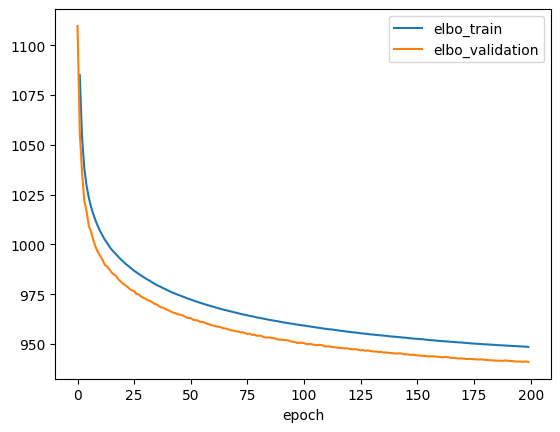

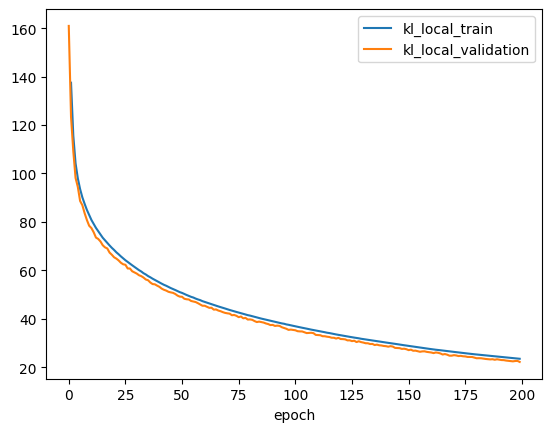

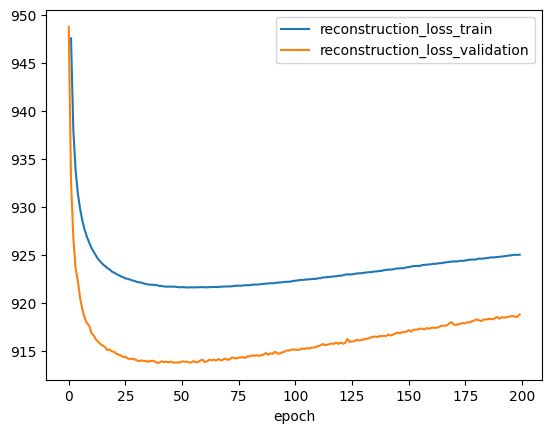

In [26]:
fig_nm = f"artifacts/{team_name}_scvi_FULL"

plot_scvi_training(model.history, fig_nm)

In [27]:
adata.obsm["X_mde"] = scvi.model.utils.mde(adata.obsm["X_scvi"])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [28]:
# artifacts
model_nm = f"artifacts/{team_name}FULL.scvi_model.pkl"
model.save(model_nm, overwrite=True)

outpt = f"artifacts/{team_name}FULL.scvi_integrated.h5ad"

adata.write_h5ad(filename=outpt, compression="gzip")

In [29]:
outpt = f"artifacts/{team_name}FULL.scvi_integrated.h5ad"

adata = sc.read_h5ad(filename=outpt)

In [30]:
model_nm = f"artifacts/{team_name}FULL.scvi_model.pkl"
model = scvi.model.SCVI.load(model_nm, adata)

INFO     File artifacts/asap-cohortFULL.scvi_model.pkl/model.pt already downloaded                                 


In [31]:
adata

AnnData object with n_obs × n_vars = 465157 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'project', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'log1p', 'pca', 'scrublet', 'target_false_positive_rate'
    obsm: 'X_mde', 'X_pca', 'X_scvi', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'gene_expression_encoding'
    varm: 'PCs'
    layers: 'counts'

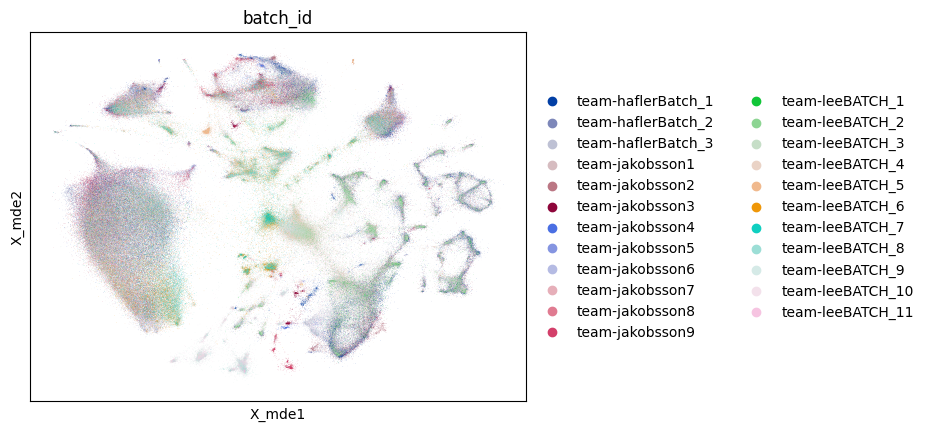

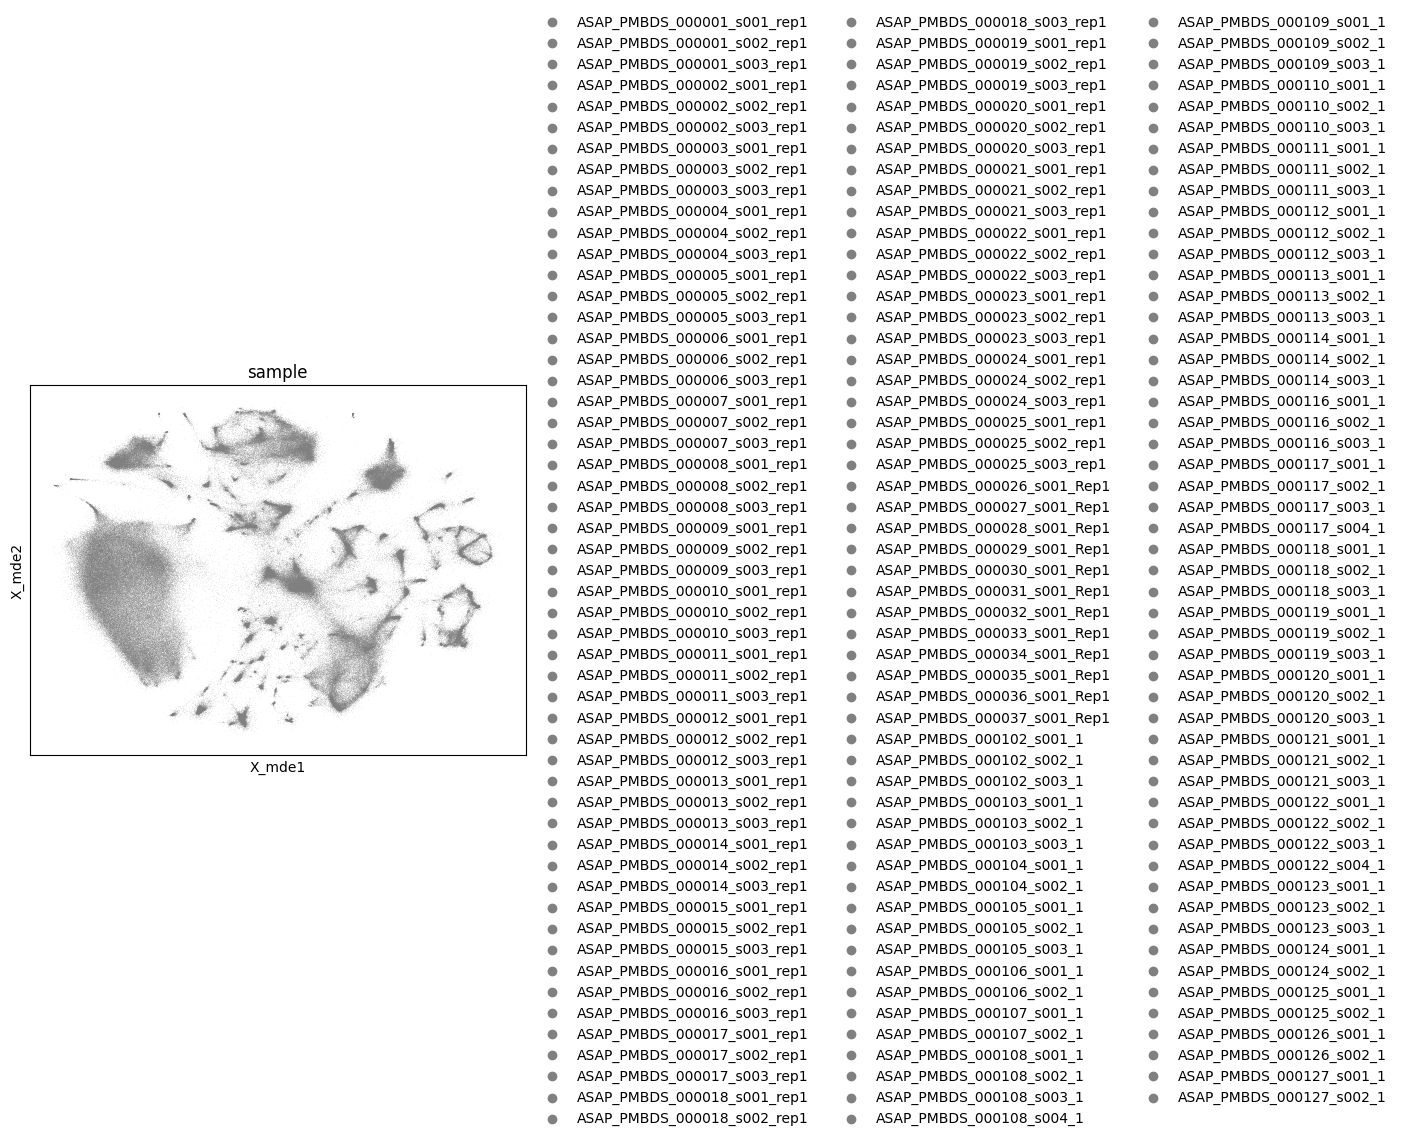

In [32]:
# sc.pl.embedding(adata, basis="X_scvi", color=['batch_id','sample'])
sc.pl.embedding(adata, basis="X_mde", color=["batch_id"])
sc.pl.embedding(adata, basis="X_mde", color=["sample"])

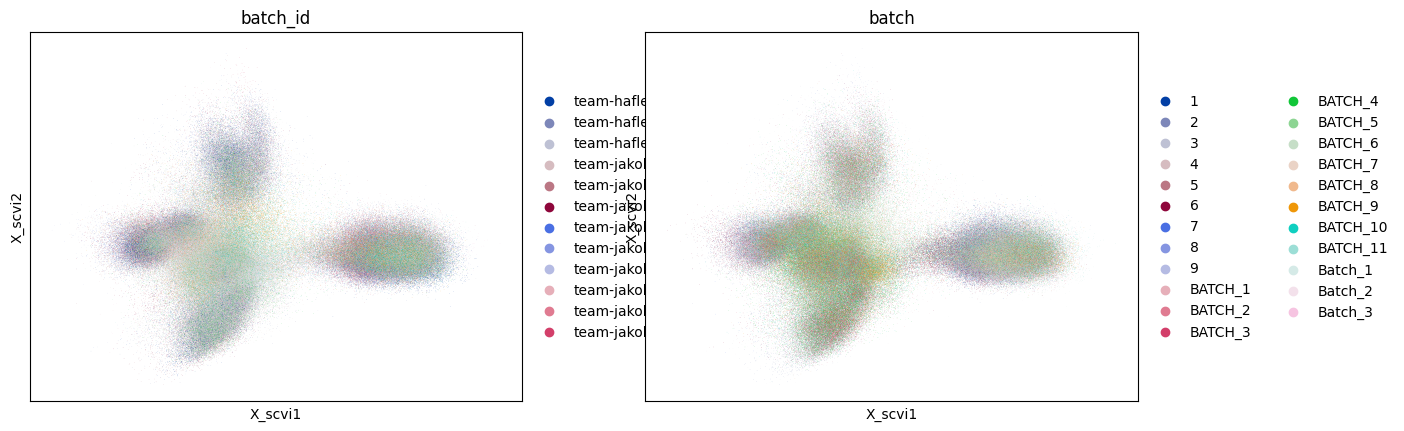

In [34]:
sc.pl.embedding(adata, basis="X_scvi", color=["batch_id", "batch"])

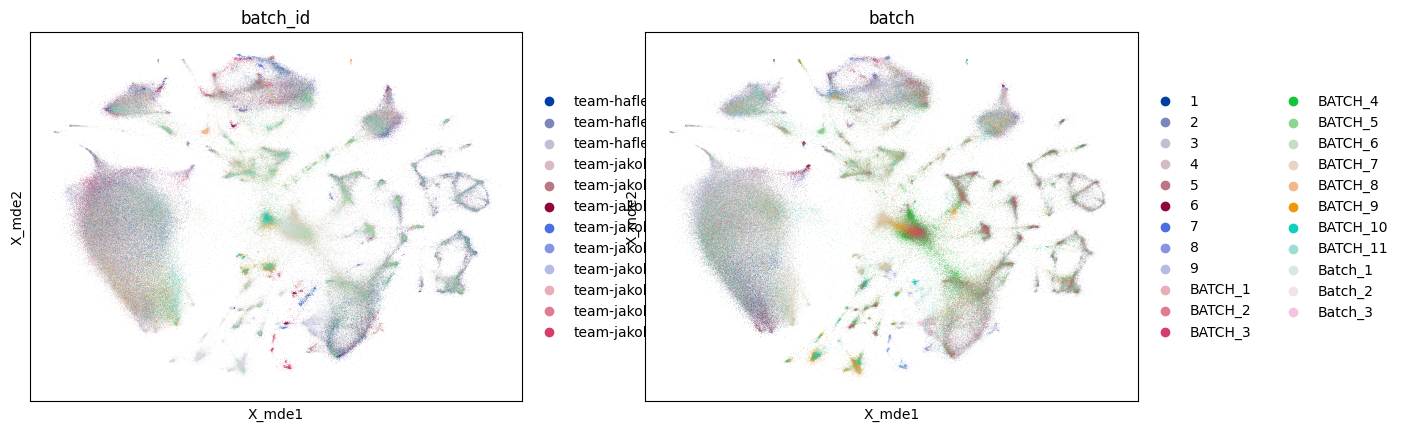

In [35]:
sc.pl.embedding(adata, basis="X_mde", color=["batch_id", "batch"])

## simpler

In [36]:
filen = Path(f"artifacts/{team_name}.merged_adata_object_filtered_normalized.h5ad")
adata = sc.read(filen)

In [37]:
# integrate the data with `scVI`
noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]

categorical_covariate_keys = [
    "sample",
    "batch",
]  # Curren
categorical_covariate_keys = None
batch_key = "batch_id"
# batch_key = "sample"
# batch_key = None

latent_key = "X_scvi"

In [38]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key=batch_key,
    continuous_covariate_keys=noise,
    categorical_covariate_keys=categorical_covariate_keys,
)


model = scvi.model.SCVI(
    adata,
    n_layers=n_layers,
    n_latent=n_latent,
    dispersion=dispersion,
    gene_likelihood=gene_likelihood,
)

model.train(
    train_size=train_size,
    max_epochs=scvi_epochs,
    early_stopping=early_stopping,
    early_stopping_patience=early_stopping_patience,
    plan_kwargs=plan_kwargs,
)

adata.obsm[latent_key] = model.get_latent_representation()  # type: ignore

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottlenec

Epoch 200/200: 100%|██████████| 200/200 [1:05:13<00:00, 19.54s/it, v_num=1, train_loss_step=911, train_loss_epoch=941]    

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [1:05:13<00:00, 19.57s/it, v_num=1, train_loss_step=911, train_loss_epoch=941]


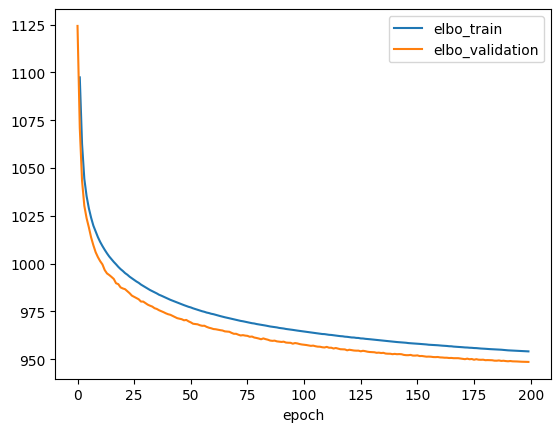

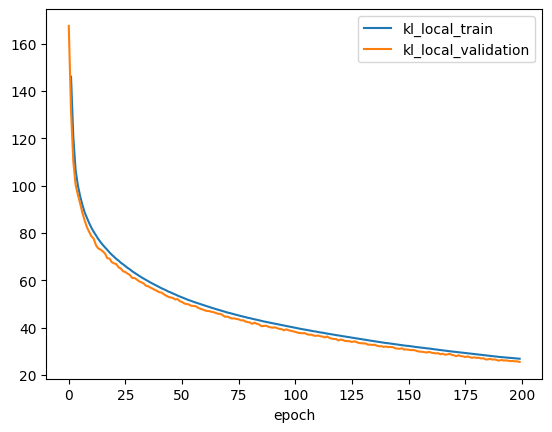

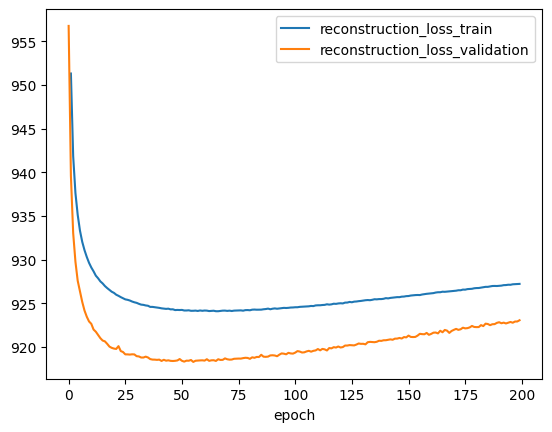

In [39]:
fig_nm = f"artifacts/{team_name}_scvi_CONT"

plot_scvi_training(model.history, fig_nm)

In [40]:
adata.obsm["X_mde"] = scvi.model.utils.mde(adata.obsm["X_scvi"])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [41]:
# artifacts
model_nm = f"artifacts/{team_name}CONT.scvi_model.pkl"
model.save(model_nm, overwrite=True)

outpt = f"artifacts/{team_name}CONT.scvi_integrated.h5ad"

adata.write_h5ad(filename=outpt, compression="gzip")

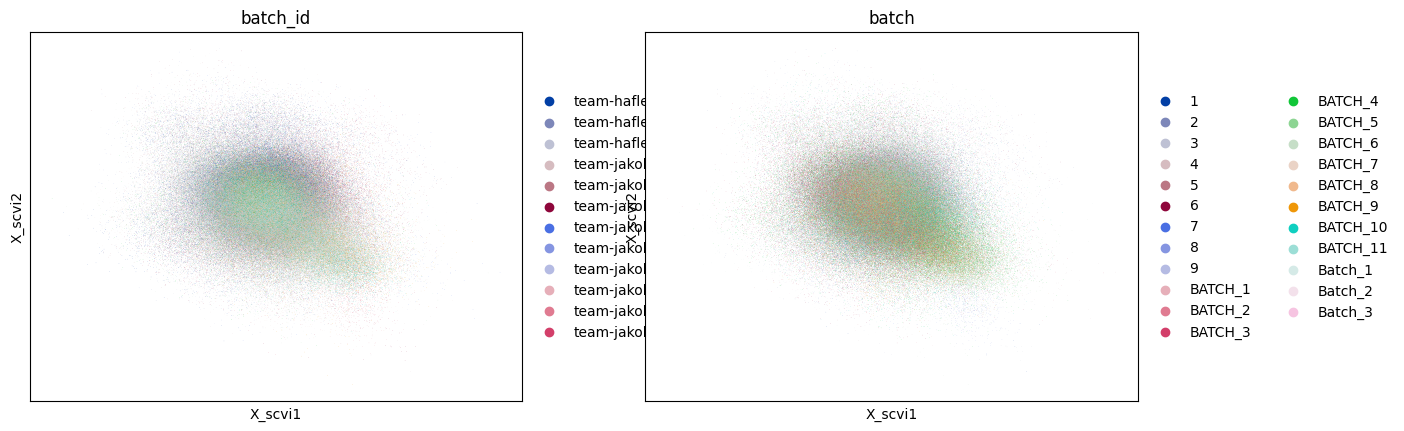

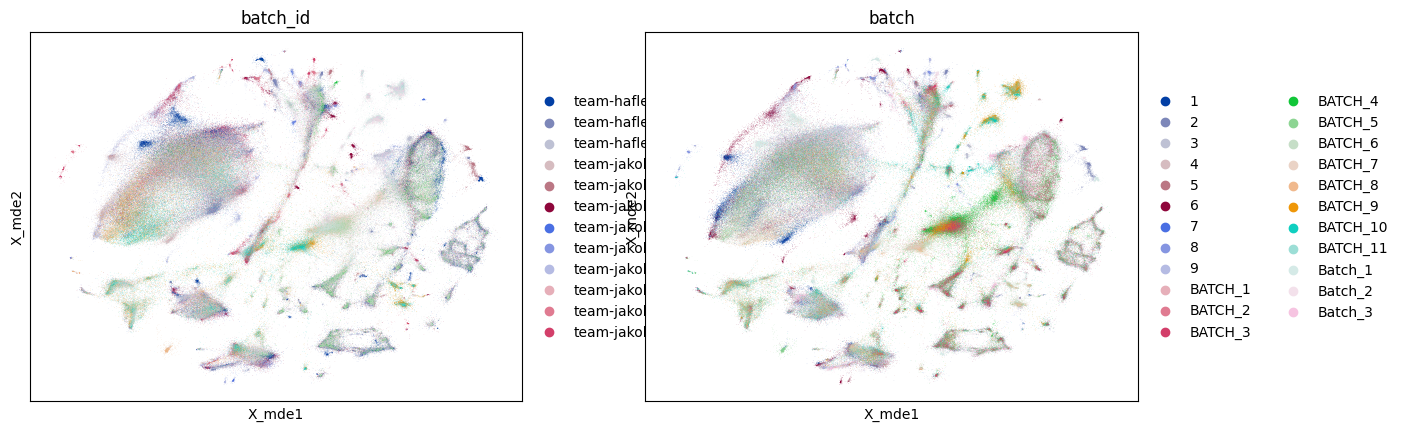

: 

In [42]:
sc.pl.embedding(adata, basis="X_scvi", color=["batch_id", "batch"])
sc.pl.embedding(adata, basis="X_mde", color=["batch_id", "batch"])

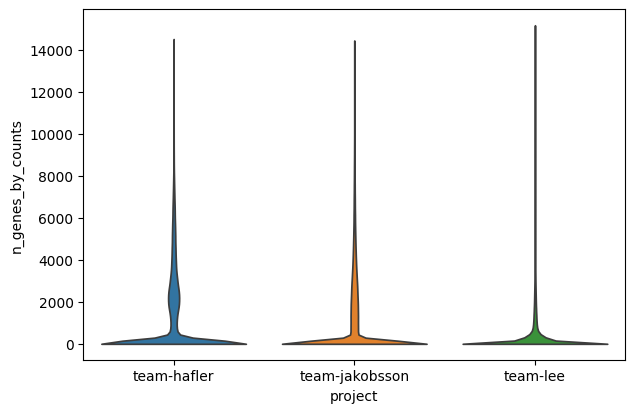

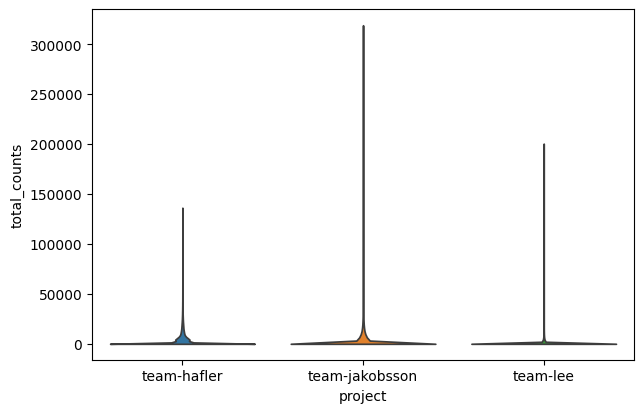

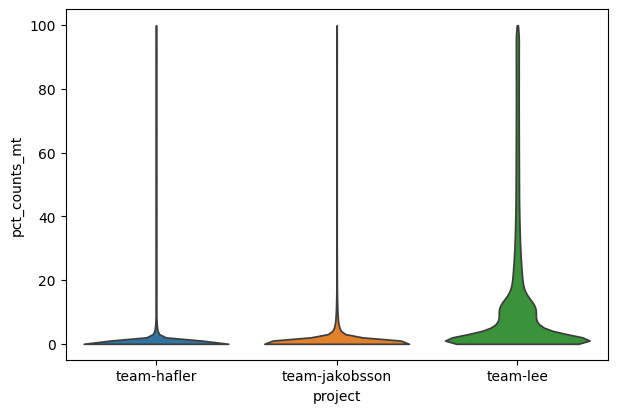

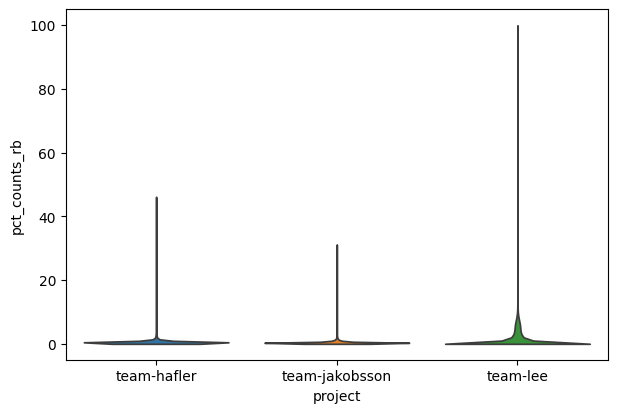

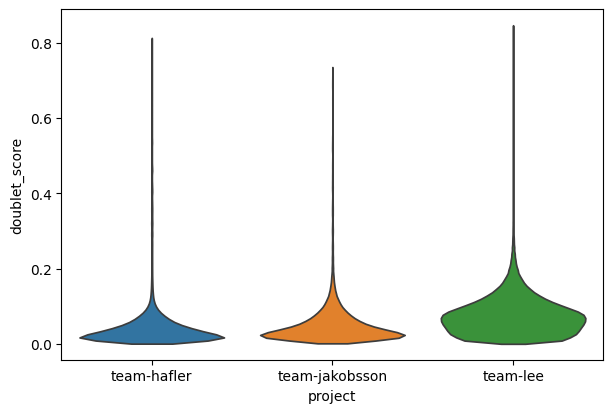

In [68]:
metrics = [
    "n_genes_by_counts",
    "total_counts",
    "pct_counts_mt",
    "pct_counts_rb",
    "doublet_score",
]

for metric in metrics:  # type: ignore
    sc.pl.violin(
        adata, groupby="project", keys=metric, size=0, save="".join("_" + metric)
    )

In [58]:
# from helpers import get_validation_metrics
import anndata as ad


def get_validation_metrics(adata: ad.AnnData, step: str):
    """Log validation metrics for adata object."""
    n_samples = adata.obs["sample"].nunique()
    n_cells = adata.n_obs
    n_genes = adata.n_vars

    # fractional metrics
    n_mito_contaminated = (adata.obs["pct_counts_mt"] > 10).sum()
    n_predicted_doublet = (adata.obs["doublet_score"] >= 0.2).sum()
    n_low_counts = (adata.obs["total_counts"] < 500).sum()
    n_high_counts = (adata.obs["total_counts"] > 100000).sum()
    n_low_genes = (adata.obs["n_genes_by_counts"] < 300).sum()
    n_high_genes = (adata.obs["n_genes_by_counts"] > 10000).sum()

    # create a dataframe with the metrics plus the column step= "concatenation"
    val_metrics = pd.DataFrame(
        {
            "step": [step],
            "n_samples": [n_samples],
            "n_cells": [n_cells],
            "n_genes": [n_genes],
            "n_mito_contaminated": [n_mito_contaminated],
            "n_predicted_doublet": [n_predicted_doublet],
            "n_low_counts": [n_low_counts],
            "n_high_counts": [n_high_counts],
            "n_low_genes": [n_low_genes],
            "n_high_genes": [n_high_genes],
        }
    )

    return val_metrics

In [61]:
output_metrics = val_metrics

In [63]:
pd.concat([output_metrics, val_metrics])

,step,n_samples,n_cells,n_genes,n_mito_contaminated,n_predicted_doublet,n_low_counts,n_high_counts,n_low_genes,n_high_genes
0,concatenation,158,1963032,36601,273519,22356,1417121,471,1371499,876
0,concatenation,158,1963032,36601,273519,22356,1417121,471,1371499,876


In [59]:
#######  validation metrics
val_metrics = get_validation_metrics(adata, "concatenation")
# log the validation metrics
val_metrics

,step,n_samples,n_cells,n_genes,n_mito_contaminated,n_predicted_doublet,n_low_counts,n_high_counts,n_low_genes,n_high_genes
0,concatenation,158,1963032,36601,273519,22356,1417121,471,1371499,876


In [60]:
output_validation_file = f"artifacts/{team_name}_output_validation.csv"
val_metrics.to_csv(output_validation_file, index=True)

In [11]:
adata.obs["batch_id"].value_counts()

batch_id
team-leeBATCH_4       51628
team-haflerBatch_2    37593
team-haflerBatch_1    28116
team-leeBATCH_10      26589
team-jakobsson2       26067
team-leeBATCH_9       25209
team-jakobsson6       25025
team-jakobsson1       24876
team-leeBATCH_6       22631
team-leeBATCH_7       22455
team-leeBATCH_3       19811
team-jakobsson9       19253
team-jakobsson3       18646
team-leeBATCH_8       17608
team-haflerBatch_3    14623
team-jakobsson8       14570
team-leeBATCH_5       13557
team-leeBATCH_2       13353
team-jakobsson5       12883
team-leeBATCH_11      12604
team-leeBATCH_1        9197
team-jakobsson4        6028
team-jakobsson7        2835
Name: count, dtype: int64

## check that our procedure for feature selction is accurate...

In [13]:
n_top_genes = 3000
marker_genes = "testing/celltype_marker_table.csv"
batch_key = "batch_id"

#  1. load marker_genes
markers = pd.read_csv(marker_genes, index_col=0)
# defensive
markers = markers[~markers.index.duplicated(keep="first")].rename_axis(index=None)

hvgs_full = sc.pp.highly_variable_genes(
    adata,
    n_top_genes=20_000,
    batch_key=batch_key,
    flavor="seurat_v3",
    check_values=True,
    layer=None,
    subset=False,
    inplace=False,
)

In [27]:
len(set(hvgs_full.gene_name)), len(set(markers.index) | set(hvgs_full.gene_name))

(36601, 36601)

In [29]:
# TODO: double check that this works...
# hvgs_full.loc[markers.index, 'highly_variable_rank'] = 1.
hvgs_full.loc[markers.index, "highly_variable_nbatches"] = (
    max(hvgs_full["highly_variable_nbatches"]) + 1
)

In [30]:
# Sort genes by how often they selected as hvg within each batch and
# break ties with median rank of residual variance across batches
hvgs_full.sort_values(
    ["highly_variable_nbatches", "highly_variable_rank"],
    ascending=[False, True],
    na_position="last",
    inplace=True,
)

In [34]:
hvgs_full_ = hvgs_full.iloc[:n_top_genes].index.to_list()
len(hvgs_full_)

3000

In [35]:
# load the raw test_ad
adata = adata[:, hvgs_full_]

In [39]:
adata.X

<465157x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 138231355 stored elements in Compressed Sparse Row format>

In [41]:
adata

View of AnnData object with n_obs × n_vars = 465157 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'project', 'batch_id', 'team'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'scrublet', 'target_false_positive_rate'
    obsm: 'gene_expression_encoding'

In [5]:
team_name = TEAM_NAMES[0]

filen = Path(
    f"artifacts/{team_name}.merged_adata_filtered_normalized_integrated_clustered_annotated.h5ad"
)
# filen = Path(f'artifacts/{team_name}.adata_object.scvi_integrated.umap_cluster.annotate_cells.h5ad')
adata = sc.read(filen)
adata

AnnData object with n_obs × n_vars = 465157 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'project', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'scrublet', 'target_false_positive_rate', 'umap'
    obsm: 'X_scvi', 'X_umap', 'gene_expression_encoding'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
sc.pp.pca(adata, n_comps=30)
adata

AnnData object with n_obs × n_vars = 465157 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'project', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'scrublet', 'target_false_positive_rate', 'umap', 'pca'
    obsm: 'X_scvi', 'X_umap', 'gene_expression_encoding', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [37]:
# do I need to compute pca for unintegrated data?
# if so scale to 10k and log1p
# adata.raw = adata
# adata = adata.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
if not "X_pca" in adata.obsm.keys():
    sc.pp.pca(adata, n_comps=30)
    filen = Path(f"artifacts/{team_name}.scib.h5ad")
    adata.write(filen)

ValueError: `A` must be of floating or complex floating data type.

In [3]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsResults


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))

In [7]:
import time

adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

biocons = BioConservation(isolated_labels=False)

start = time.time()
bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "X_scvi"],
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    n_jobs=-1,
)

In [47]:
# bm.prepare()
report_dir = Path.cwd() / "scib_report"
if not report_dir.exists():
    report_dir.mkdir(parents=True, exist_ok=True)

Computing neighbors:   0%|          | 0/2 [00:00<?, ?it/s]

Computing neighbors: 100%|██████████| 2/2 [02:10<00:00, 65.26s/it]


In [8]:
bm.prepare(neighbor_computer=faiss_brute_force_nn)

bm.benchmark()
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Computing neighbors:   0%|          | 0/2 [00:00<?, ?it/s]

Embeddings:   0%|          | 0/2 [00:00<?, ?it/s]/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a fu

Time: 24 min 49 sec


/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/home/ergonyc/mambaforge/envs/scib3/lib/python3.11/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error

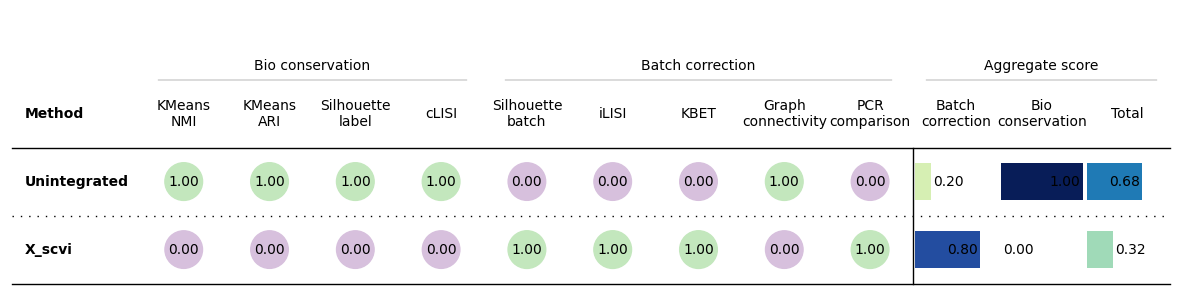

In [9]:
bm.plot_results_table()

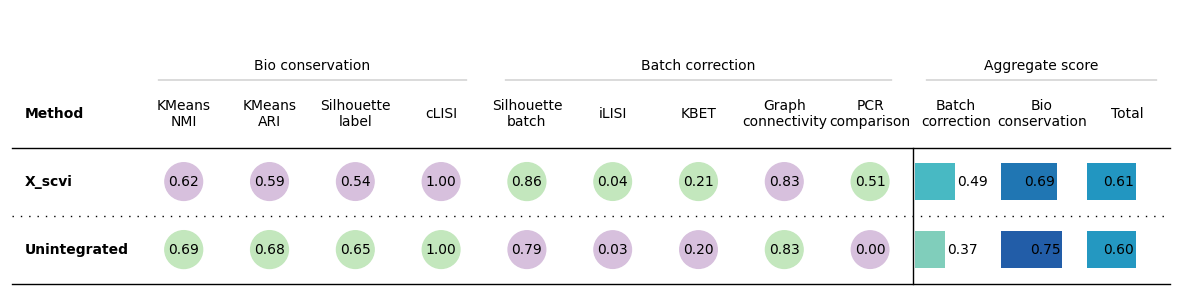

In [10]:
bm.plot_results_table(min_max_scale=False)

In [54]:
out_path = Path.cwd() / "artifacts/scib_metrics/"
if not out_path.exists():
    out_path.mkdir()

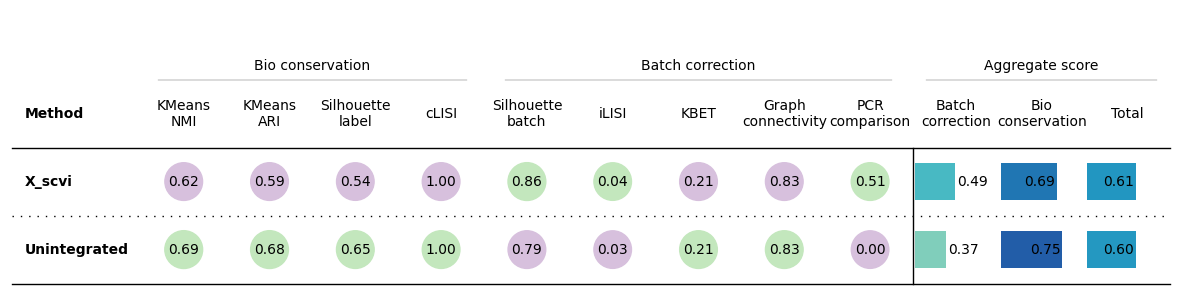

In [55]:
bm.plot_results_table(min_max_scale=False, save_dir=out_path)
df = bm.get_results(min_max_scale=False)
df.to_csv((out_path / "results.csv"), index=False)

In [52]:
df.to_csv((out_path / "results.csv"), index=False)

NameError: name 'df' is not defined